Коллеги из ML-отдела планируют выкатывать новый алгоритм, рекомендующий нашим пользователям интересные посты. По результатам обсуждения были сделаны следующие выводы:
Алгоритм добавляет пользователям 1-2 просмотра
Вероятность того, что он сработает, составляет 90%
Если у пользователя меньше 50 просмотров, то алгоритм не сработает

Возникает предположение, что увеличение числа просмотров приведёт и к увеличению лайков на пользователя. 

Можем ли мы обнаружить различия в среднем количестве лайков на пользователя? 

Попробуем ответить на этот вопрос

In [1]:
# Импортируембиблиотеки
import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

#Создаём генератор псевдослучайных чисел
rng = np.random.default_rng()

In [2]:
# Подключаемся к данным
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Для начала вытащим данные по просмотрам и CTR за период АА-теста и подготовим их нужным образом

In [3]:
# Получаем просмотры
q = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
from simulator_20250320.feed_actions
where toDate(time) between '2025-02-14' and '2025-02-20'
group by user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.head()

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [4]:
# Получаем CTR 
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20250320.feed_actions
where dt between '2025-02-14' and '2025-02-20'
group by dt, user_id
)
group by ctr
"""

#эмпирическое распределение
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.head()

,ctr,users,p
0,0.00,1443,0.016952
1,0.65,4,0.000047
2,0.71,5,0.000059
3,0.49,4,0.000047
4,0.54,72,0.000846


In [5]:
# Определяем количество пользователей в АА-тесте
q = """
select uniqExact(user_id)
from simulator_20250320.feed_actions
where toDate(time) between '2025-02-14' and '2025-02-20'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,41997


In [6]:
# Определяем размер группы
np.floor(41997 / 2)

20998.0

Теперь посмотрим на распределения, которые мы генерируем на основе реальных

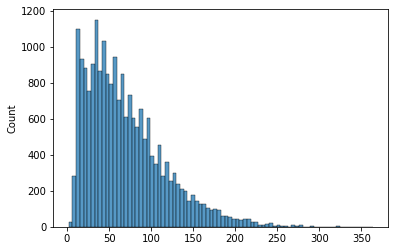

In [7]:
sim_views = rng.choice(a=views_distribution.views, size=20998, replace=True, p=views_distribution.p)
sns.histplot(sim_views)

На графике просмотров видна явная асимметрия. Если присмотреться, то можно даже заметить небольшую двухгорбость

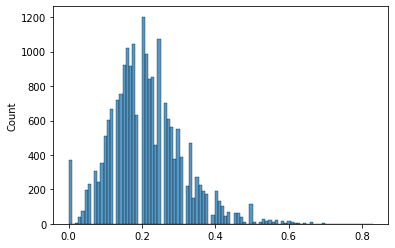

In [8]:
sim_ctrs = rng.choice(a=ctr_distribution.ctr, size=20998, replace=True, p=ctr_distribution.p)
sns.histplot(sim_ctrs)

CTR выглядят разреженными, что ожидаемо, потому что фактически округлили непрерывную величину и сэмплировали эти округлённые значения, а любые промежуточные значения генерироваться не будут

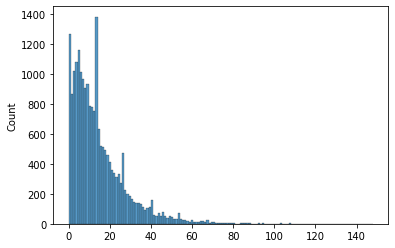

In [9]:
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctrs)
sns.histplot(sim_clicks)

График лайков в целом похож на распределение просмотров, но выглядит ещё более асимметричным

Для начала сделаем искусственный АА-тест и убедимся, что доля ложноположительных результатов (False Positive Rate, FPR) примерно равно значению альфа (0.05)

In [10]:
#функция для расчёта FPR

def fpr_calc(sample_size, views_df, ctr_df, nsim=1000):
    """
    Считает FPR для t-теста при заданных параметрах распределения
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симулируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем FPR
    return np.mean(np.array(pvalues) < 0.05)

In [11]:
fpr_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000)

100%|██████████| 20000/20000 [06:25<00:00, 51.84it/s]


0.05375

Результат довольно близок к ожидаемому

В идеале стоит повторить эти симуляции несколько раз и получить не только среднее значение FPR, но и доверительный интервал, чтобы убедиться в правильности данного вывода, но в данном случае временные затраты делают это нецелесообразным, поэтому поверим имеющимся данным

Теперь начнем отвечать на поставленный вопрос

In [12]:
1 + rng.binomial(n=1, p=0.5, size=20998)

array([1, 1, 1, ..., 2, 1, 1])

Здесь мы создали последовательность из 1 и 2, в соотношении примерно 50/50. Фактически мы генерируем 0 и 1 с вероятностью в 50%, а потом добавляем к ним всем 1

In [13]:
rng.binomial(n=1, p=0.9, size=20998)

array([1, 1, 1, ..., 1, 1, 1])

Далее мы создаём "маску" из 0 и 1 - те, для кого алгоритм (не) сработал. Так как вероятность 90%, большая часть значений будет единичками

In [14]:
sim_views >= 50

array([ True, False, False, ..., False,  True, False])

В конце отбираем пользователей с числом просмотров большим либо равным 50

In [15]:
rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50)

array([1, 0, 0, ..., 0, 1, 0])

Когда мы всё это перемножили, у нас появился массив из 0, 1, 2, где:

* 0 - это пользователи, для которых алгоритм не сработал по одной из двух причин. Либо у него просмтров мало, либо ему просто не повезло и он попал в 10%. Возможно, даже оба варианта сразу
* 1 - один просмотр
* 2 - два просмотра

Запомним этот шаг. Потом мы к нему еще вернемся

In [16]:
sim_views + (rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50))

array([90., 38., 28., ..., 32., 69., 39.])

Добавляем это к нашим просмотрам и видим эффект. Потом мы на основе этого будем генерировать лайки, которые нас и интересуют в данном случае

In [17]:
# Считаем мощность
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [18]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=50, nsim=20000)

100%|██████████| 20000/20000 [06:43<00:00, 49.61it/s]


0.25605

Получается мощность где-то в районе 25.6%. Это чудовищно мало

Коллеги улучшили качество алгоритма и теперь он срабатывает на пользователях с числом просмотров от 30 и выше, после чего попросили 

In [19]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [06:39<00:00, 50.01it/s]


0.42135

Теперь у нас мощность около 41.7%. Это всё ещё очень мало

Попробуем увеличить длительность эксперимента до 2 недель и посмотреть на результаты

In [21]:
q = """
select uniqExact(user_id)
from simulator_20250320.feed_actions
where toDate(time) between '2025-02-14' and '2025-02-27'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,61182


In [22]:
np.floor(61182 / 2)

30591.0

In [23]:
power_calc(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [09:19<00:00, 35.74it/s]


0.5608

Мощность где-то около 56%. Мы всё ближе к цели, но заветного порога в 80% мы ещё не достигли

До этого в исследованиях мы использовали данные всех пользователей, т.е. в массиве были пользователи, на которых эффект не сработал. Сейчас мы от них избавимся и попробуем посчитать только на нужных пользователях, т.е. на пользователях с числом просмотров >=30

In [24]:
def power_calc_masked(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта + отсекает пользователей ниже нужного порога
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #маска для отсеивания лишних пользователей
        mask_A = group_A_views>=threshold
        mask_B = group_B_views>=threshold

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [25]:
power_calc_masked(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|██████████| 20000/20000 [09:32<00:00, 34.94it/s]


0.6424

Получается где-то 64.3%. Ближе, но все равно не дотягиваем до 80%

Вывод: после всех предпринятых попыток так и не получилось добраться до мощности в 80%. 

Есть несколько вариантов развития событий:
* отказаться от идеи эксперимента вообще. Раз у нас не хватает ресурсов для детекции такого изменения, то и смысла особо действовать нет;
* всё равно запустить эксперимент и надеяться на лучшее. Платой за это решение будет меньшая уверенность в полученных результатах;
* дорабатывать алгоритм, чтобы его эффект либо распространялся на большее число пользователей, либо чтобы он был больше.
* попробовать найти большее количество пользователей и пересчитать симуляцию. может, вы всё-таки получится набрать достаточное количество
* поменять уровень значимости на более высокий. Платой за это будет большая вероятность ложноположительного результата.